In [88]:
import pandas as pd
import numpy as np
import glob

# Load monitoring data from FC1 (learning dataset)
file_paths = sorted(glob.glob("C:/Users/Rajashri/Downloads/IEEE2014DataChallengeData/IEEE 2014 Data Challenge Data/FC1_Without_Ripples/FC1_Ageing_Part*.csv"))  # adjust path if needed

# Combine all parts
# Try reading with comma separator instead
df_all = pd.concat([pd.read_csv(f, sep=',', encoding='ISO-8859-1') for f in file_paths])

# Use stack voltage as primary variable (column 7, Utot)
voltage_data = df_all['Utot (V)'].values  # if available by name


In [89]:
voltage_data

array([3.317, 3.317, 3.316, ..., 3.208, 3.203, 3.211])

In [90]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Clean outliers
voltage_data = voltage_data.reshape(-1, 1)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
inlier_mask = lof.fit_predict(voltage_data) == 1
voltage_clean = voltage_data[inlier_mask].flatten()

# Normalize
scaler = StandardScaler()
voltage_scaled = scaler.fit_transform(voltage_clean.reshape(-1, 1)).flatten()

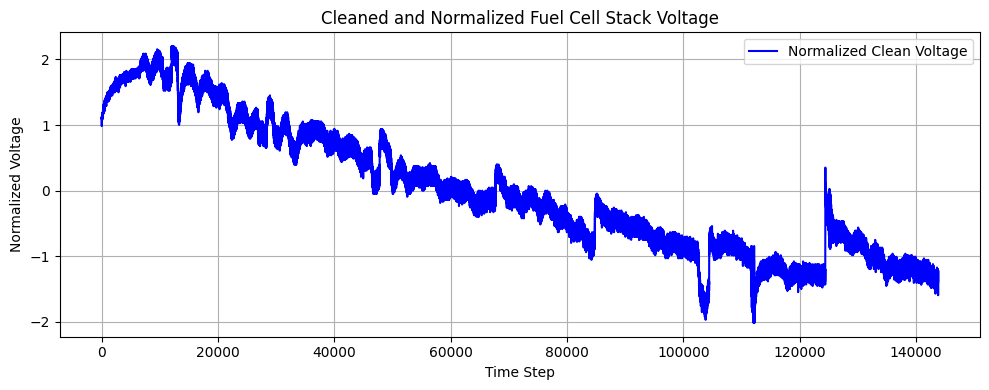

In [91]:
import matplotlib.pyplot as plt

# Generate a time axis based on index (since actual time isn't preserved after cleaning)
time_clean = np.arange(len(voltage_scaled))  # or use df_all['Time (h)'].values[inlier_mask] if available

plt.figure(figsize=(10, 4))
plt.plot(time_clean, voltage_scaled, label='Normalized Clean Voltage', color='blue')
plt.title('Cleaned and Normalized Fuel Cell Stack Voltage')
plt.xlabel('Time Step')
plt.ylabel('Normalized Voltage')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

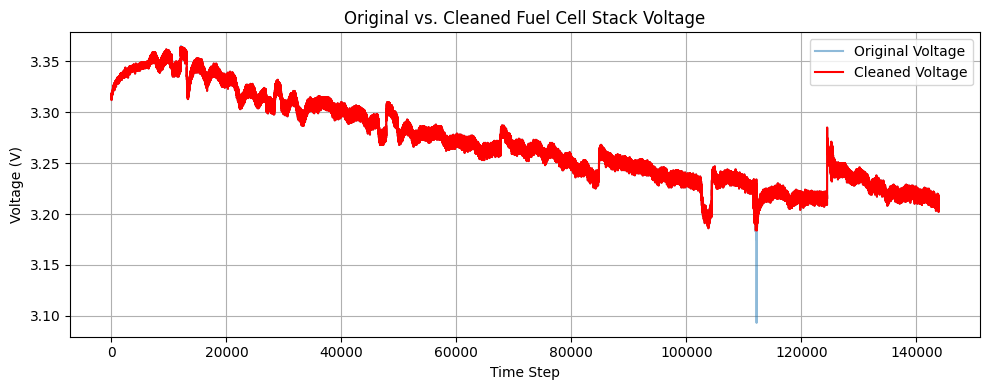

In [92]:
# Undo normalization for comparison (optional)
voltage_raw = voltage_data.flatten()

plt.figure(figsize=(10, 4))
plt.plot(voltage_raw, label='Original Voltage', alpha=0.5)
plt.plot(inlier_mask.nonzero()[0], voltage_clean, label='Cleaned Voltage', color='red')
plt.title('Original vs. Cleaned Fuel Cell Stack Voltage')
plt.xlabel('Time Step')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [226]:
# Downsample voltage (e.g., every 5th point)
voltage_scaled_downsampled = voltage_scaled[::300]

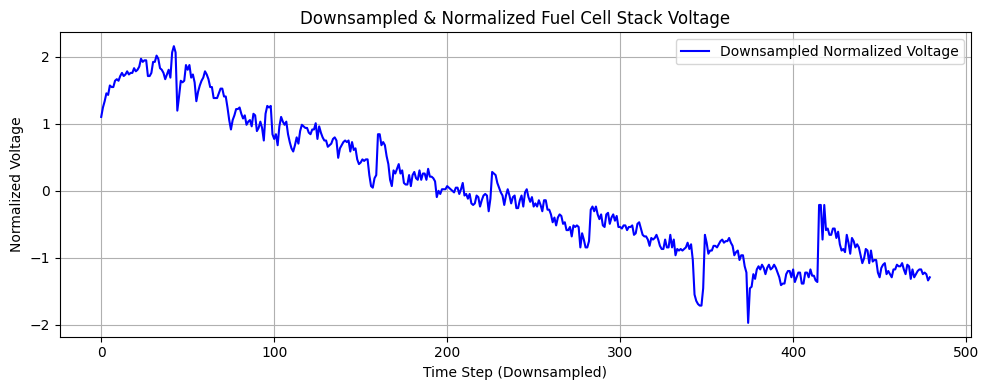

In [227]:
import matplotlib.pyplot as plt
import numpy as np

# Generate time axis for downsampled data
time_downsampled = np.arange(len(voltage_scaled_downsampled))

plt.figure(figsize=(10, 4))
plt.plot(time_downsampled, voltage_scaled_downsampled, label='Downsampled Normalized Voltage', color='blue')
plt.title('Downsampled & Normalized Fuel Cell Stack Voltage')
plt.xlabel('Time Step (Downsampled)')
plt.ylabel('Normalized Voltage')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [228]:
sequence_length = 256

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)])

sequences = create_sequences(voltage_scaled_downsampled, sequence_length)

def pad_soc_to_3D(data):
    return np.repeat(data[..., np.newaxis], 3, axis=-1)

sequences_3D = pad_soc_to_3D(sequences)


In [229]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_seq, test_seq = train_test_split(sequences_3D, test_size=0.2, shuffle=False)
val_seq, test_seq = train_test_split(test_seq, test_size=0.5, shuffle=False)

train_data = tf.convert_to_tensor(train_seq, dtype=tf.float32)
val_data = tf.convert_to_tensor(val_seq, dtype=tf.float32)
test_data = tf.convert_to_tensor(test_seq, dtype=tf.float32)

# Flatten
train_data_flat = tf.reshape(train_data, (-1, 3))
val_data_flat = tf.reshape(val_data, (-1, 3))
test_data_flat = tf.reshape(test_data, (-1, 3))


train_data_flat = tf.cast(train_data_flat, tf.float32)
val_data_flat = tf.cast(val_data_flat, tf.float32)
test_data_flat = tf.cast(test_data_flat, tf.float32)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data_flat, val_data_flat)).batch(256)


In [230]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(179, 256, 3)
(23, 256, 3)
(22, 256, 3)


In [231]:
train_data_flat.shape

TensorShape([45824, 3])

In [232]:
val_data_flat.shape

TensorShape([5632, 3])

In [233]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

In [234]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(500, activation="relu")
        self.dense2 = Dense(32, activation="tanh") 
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.1) 

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.layer_norm(x)  # Apply LayerNormalization after the dense layer
        x = self.dropout(x)
        return x

In [235]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(latent_dim, latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        len = tf.shape(Z)[0]
        latent_dim = tf.shape(Z)[1]
        
        # Determine the actual trajectory length to use
        if len > self.S:
            trajLength = self.S
            Z1 = Z[0:trajLength+1]
        else:
            trajLength = len - 1  # Ensure we have room for shifting
            Z1 = Z
        
        # Make sure we don't go out of bounds
        z_shift = Z1[1:trajLength+1, :]
        z_first = Z1[0, :]
        
        # Initialize Z2_tilde with the correct size to match z_shift
        Z2_tilde = tf.zeros([trajLength, latent_dim], dtype=tf.float32)
        
        for m in range(trajLength):
            indices = tf.constant([[m]])
            if m == 0:
                updates = [tf.linalg.matvec(self.K, z_first)]
            else:
                updates = [tf.linalg.matvec(self.K, z_shift[m-1, :])]
            
            Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
        
        return Z1, Z2_tilde, z_shift

# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [236]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(500, activation="relu")
        self.output_layer = Dense(3)  

    def call(self, input1, input2):
        z = input1
        z2_tilde = input2
        
        x = self.dense(z)
        x2 = self.dense(z2_tilde)

        return self.output_layer(x), self.output_layer(x2)

In [237]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde = self.dec(z, z2_tilde)
        return x_hat, x2_tilde


In [238]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 1.0
        alpha2 = 10.0
        alpha3 = 1e-6
        
        x2 = x[1:self.S+1]
        
        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        # recon_loss = tf.reduce_mean(tf.abs(tf.subtract(x, x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))
        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        
        return alpha1*recon_loss + alpha2*predict_loss + alpha3*lossL2
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10  
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                
                with tf.GradientTape() as tape:
                    reconstruction, linearity= model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, linearity_val= model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))
        
        import matplotlib.pyplot as plt
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_train_loss, label='Training Loss')
        plt.plot(epoch_validation_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs. Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()




In [239]:
train_data.shape

TensorShape([179, 256, 3])

In [240]:
print(train_data_flat.shape)

(45824, 3)



Start of epoch 0
Average training loss at epoch 0: 1.9257558
Epoch val loss: 0.2544661218469793
Time taken: 75.71s

Start of epoch 1
Average training loss at epoch 1: 0.4543881
Epoch val loss: 0.2382814667441628
Time taken: 151.06s

Start of epoch 2
Average training loss at epoch 2: 0.2285637
Epoch val loss: 0.23711440779946066
Time taken: 226.56s

Start of epoch 3
Average training loss at epoch 3: 0.1917530
Epoch val loss: 0.23659775473854758
Time taken: 303.86s

Start of epoch 4
Average training loss at epoch 4: 0.1841497
Epoch val loss: 0.23637609048323197
Time taken: 382.12s

Start of epoch 5
Average training loss at epoch 5: 0.1811472
Epoch val loss: 0.23612837357954544
Time taken: 457.35s

Start of epoch 6
Average training loss at epoch 6: 0.1791427
Epoch val loss: 0.23600064624439587
Time taken: 532.17s

Start of epoch 7
Average training loss at epoch 7: 0.1777945
Epoch val loss: 0.23592825369401413
Time taken: 606.40s

Start of epoch 8
Average training loss at epoch 8: 0.17679

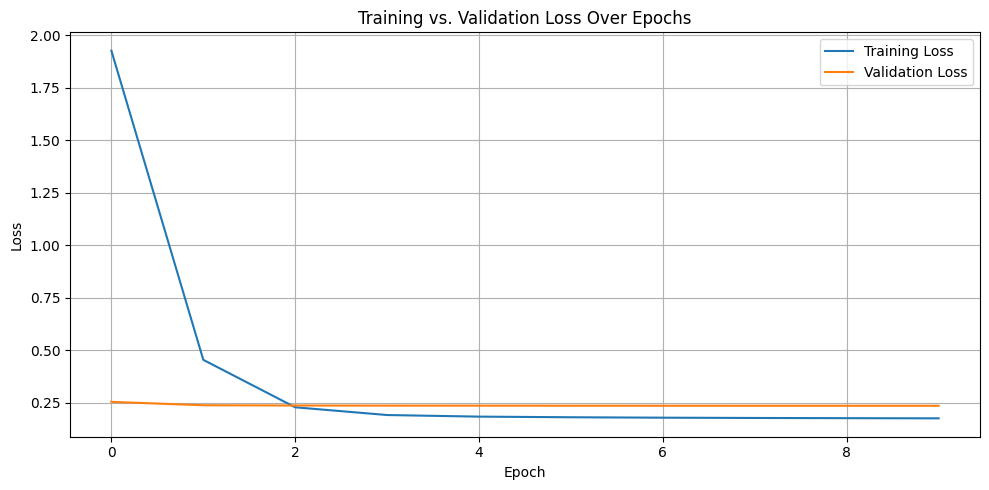

In [241]:
# Constants
trajLength = 256
numTraj = train_data.shape[0]
numTraj_val = val_data.shape[0]
batch_size = 256
S = trajLength - 1

num_batches_train = int(trajLength * numTraj / batch_size)
num_batches_val = int(trajLength * numTraj_val / batch_size)

# Initialize and train
Training_class = MyStaticModel(input_dim=3, batch_size=batch_size, S=S,
                               num_batches_train=num_batches_train,
                               num_batches_val=num_batches_val)

koopmanAEModel = Koopman_AE_Model(S)
Training_class.fit(koopmanAEModel,
                   x=train_data_flat,
                   y=train_data_flat,
                   validation_data=val_dataset,
                   batch_size=batch_size)

In [242]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[ 0.06878885,  0.09552561,  0.0329701 , ..., -0.04741182,
         0.01760014, -0.07273884],
       [ 0.07688009, -0.05435308,  0.05094176, ..., -0.03842822,
        -0.0503396 , -0.00547184],
       [ 0.0657865 ,  0.01399776, -0.01205771, ...,  0.01808806,
        -0.02272101, -0.10271017],
       ...,
       [ 0.09793027,  0.00831029,  0.05139496, ...,  0.09451324,
         0.03363805, -0.08032285],
       [ 0.00080805, -0.07564483, -0.03436853, ...,  0.08128098,
         0.03541252,  0.09533105],
       [ 0.02534533,  0.01209119, -0.04699535, ..., -0.01603423,
        -0.01934752, -0.01346906]], dtype=float32)]


In [243]:
test_data

<tf.Tensor: shape=(23, 256, 3), dtype=float32, numpy=
array([[[ 0.04507523,  0.04507523,  0.04507523],
        [ 0.0216197 ,  0.0216197 ,  0.0216197 ],
        [-0.00183584, -0.00183584, -0.00183584],
        ...,
        [-1.2449794 , -1.2449794 , -1.2449794 ],
        [-1.1980683 , -1.1980683 , -1.1980683 ],
        [-1.2449794 , -1.2449794 , -1.2449794 ]],

       [[ 0.0216197 ,  0.0216197 ,  0.0216197 ],
        [-0.00183584, -0.00183584, -0.00183584],
        [-0.02529138, -0.02529138, -0.02529138],
        ...,
        [-1.1980683 , -1.1980683 , -1.1980683 ],
        [-1.2449794 , -1.2449794 , -1.2449794 ],
        [-1.2918904 , -1.2918904 , -1.2918904 ]],

       [[-0.00183584, -0.00183584, -0.00183584],
        [-0.02529138, -0.02529138, -0.02529138],
        [ 0.04507523,  0.04507523,  0.04507523],
        ...,
        [-1.2449794 , -1.2449794 , -1.2449794 ],
        [-1.2918904 , -1.2918904 , -1.2918904 ],
        [-1.1746128 , -1.1746128 , -1.1746128 ]],

       ...,

      

In [244]:
test_data_flat = tf.reshape(test_data, (-1, 3))
res = koopmanAEModel(test_data_flat[:batch_size])


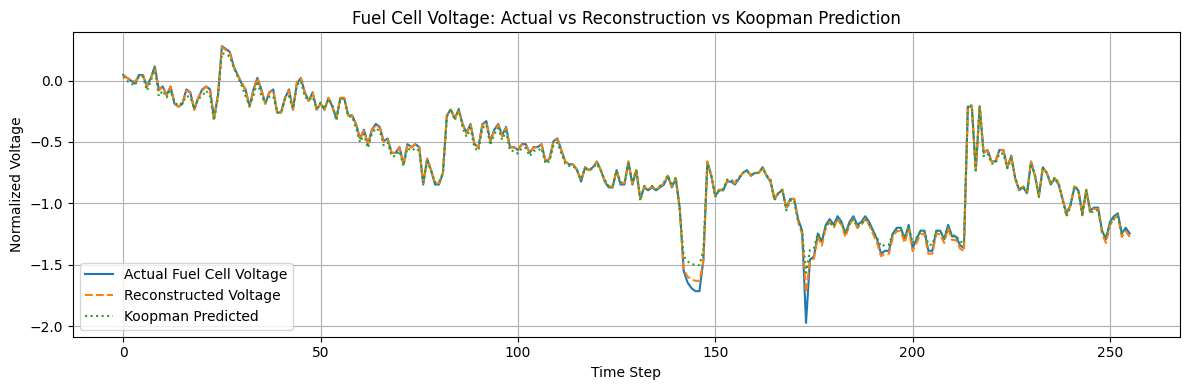

In [245]:
plt.figure(figsize=(12, 4))
plt.plot(test_data_flat[:batch_size, 0], label='Actual Fuel Cell Voltage')
plt.plot(res[0][:, 0], label='Reconstructed Voltage', linestyle='--')
plt.plot(res[1][:, 0], label='Koopman Predicted', linestyle=':')
plt.title("Fuel Cell Voltage: Actual vs Reconstruction vs Koopman Prediction")
plt.xlabel("Time Step")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Multistep Prediction

In [250]:
def predict_future_koopman(model, x0, steps, plot_norms=False):
    z = model.enc(x0)
    z_preds = [z]
    z_norms = [tf.norm(z).numpy()]

    for _ in range(steps):
        z_next = tf.linalg.matvec(model.koopman.koopman.K, z_preds[-1])
        z_preds.append(z_next)
        z_norms.append(tf.norm(z_next).numpy())

    z_preds = tf.stack(z_preds[1:])  # shape: (steps, latent_dim)
    x_preds = model.dec.output_layer(model.dec.dense(z_preds))  # shape: (steps, 3)

    if plot_norms:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 3))
        plt.plot(z_norms, marker='o')
        plt.title("Norm of Latent Vector z over Prediction Steps")
        plt.xlabel("Prediction Step")
        plt.ylabel("||z||")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return x_preds

In [251]:
# Pick an index so you have enough room to compare future values
start_idx = 1000
TSP = 100 # Predict 100 steps ahead

# Initial point: single 3D state
x0 = test_data_flat[start_idx]  # shape (3,)
x0 = tf.expand_dims(x0, 0)  # make it (1, 3)

# True future: 100 steps from start_idx
true_future = test_data_flat[start_idx + 1: start_idx + 1 + TSP]

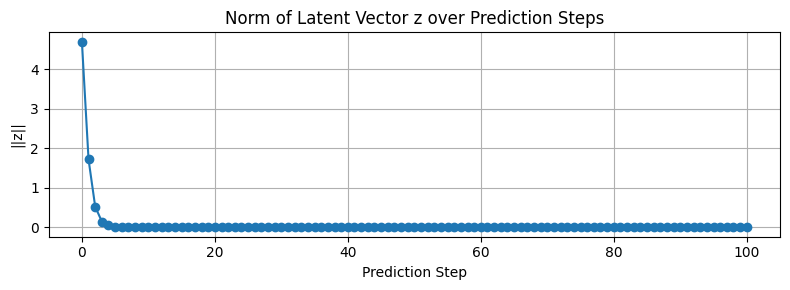

RMSE: 0.5955, MAPE: 99.86%


In [252]:
predicted_future = predict_future_koopman(koopmanAEModel, x0, TSP, plot_norms=True)

# Compare just voltage (first dimension)
y_true = true_future[:, 0].numpy()
y_pred = predicted_future[:, 0].numpy()
y_pred = y_pred[:, 0]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")


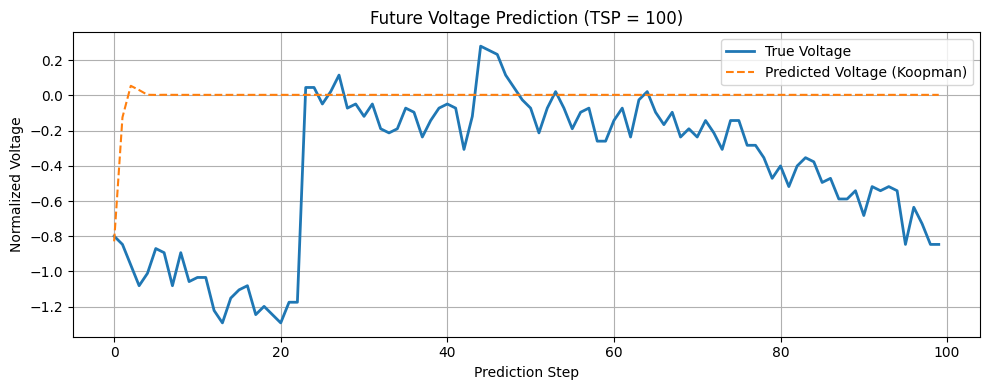

In [253]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_true, label="True Voltage", linewidth=2)
plt.plot(y_pred, label="Predicted Voltage (Koopman)", linestyle='--')
plt.title(f"Future Voltage Prediction (TSP = {TSP})")
plt.xlabel("Prediction Step")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
